<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_Arch_to_LDS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architecture to LDS Data Experiments v1
LDS = "Laser Distance Sensor"

In [52]:
# Setup common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#from IPython.display import Image
from PIL import Image
import requests
import math

In [53]:
# Load single black'n'white image as source data from github
#arch = Image.open()
url = "https://github.com/malcolmlett/robovac/blob/main/data/experimental-architecture1.png?raw=true"
arch = Image.open(requests.get(url, stream=True).raw)
arch = np.array(arch, dtype=np.bool_)
arch.shape

(84, 94)

In [54]:
# Pick a coordinate as our location (x,y)
loc = (60, 25)

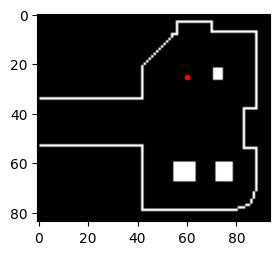

In [55]:
# Show what we've got, and overlay a coloured dot on the coordinate of loc
plt.figure(figsize=(3, 3))
plt.imshow(arch, cmap='gray')
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.show()

## Generate LDS Data
Assumptions in approach:
* Laser traces are have infinitesimal width
* All decimal-valued coordinates identify infinitesimal width positions somewhere within the width of the pixel that it overlays. With `#.0` at the near-origin side of the pixel, and `#.9999` at the opposite side of the same pixel.
* All integer-valued coordinates identify a pixel-width square spanning the range `(#.0,#.0)` to `(#.9999,#.9999)` and with its centre at `(#.5,#.5)`.

For collision with individual pixels, the approach is:
* Treat each pixel as a circle, having a centre in the middle of the pixel and a diameter equal to the _diagonal_ of the pixel (ie: $\sqrt{2}$).
* Additionally, each pixel has a holographic line that always passes through the centre and has a normal in the direction of the trace. The line extends out from the centre in both directions with radius equal to the radius of the pixel.
* A collision in determined by doing the single linear algebra dot-product trick to identify the intersection point between the trace and the pixel's line, and then to check whether the intersection is within the line radius.
* When selecting between potential collisions, the min distance to intersection point is taken.

Algorithm:
* `step_size` = position increment used by traces, in their direction
* `grid_size` = distance between centres of nearest-neighbours cache grid
* `step_size` = `grid_size`
* Nearest-neighbours bubble size: radius = grid_size
  * This ensures that the bubbles overlap considerably on horizontal/vertical and diagonal axies.
  * It's possible that it'd work with 0.5*sqrt(2)*step-size - so that the bubbles meet exactly on the diagonal and overlap a little on the horizontal/vertical. However there's potentially an edge case with traces jumping semi-diagonally over a bubble and missing potential collisions. The larger bubble size resolves this, I believe.

1. Initialise a grid of cached nearest-neighbour "bubbles", having a circular shape and containing a count + list of all pixels within its area.
1. Initialise 360 traces, with:
  * initial position at centre
  * step (x,y) calculated according to their angle and the step size
  * a value indicating how much of the trace has been consumed (in range 0.0 to 1.0)
  * a value indicating its current range (initially NaN)
1. Proceed with all traces simultaneously:
  1. Take one step
  1. Identify the single cache bubble having the nearest centre by doing a `round(x,y)/grid_size` operation against the trace's position to identify the array lookups into the cache for each trace
1. For each trace that hasn't already been consumed and for which the cache has pixels:
  1. Compute for all pixels within the cache bubble simultaneously
  1. Compute the intersection points with each pixel's holographic line.
  1. Filter to remove all intersections that are > pixel radius from the pixel centre.
  1. Compute the distances to each remaining intersection point.
  1. Take the min distance, if any remain.
  1. For all traces that have had collisions, mark them as consumed.


In [95]:
# Let's validate the maths for computing the intersection point
A_origin = np.array([3, -1])
B_origin = np.array([0, 0])
B_direction = np.array([0.5, 0.5])
delta_origin = A_origin - B_origin
t = np.dot(delta_origin, B_direction) / np.dot(B_direction, B_direction)
intersection = B_origin + t * B_direction
print(f"intersection: {intersection}, t: {t}")

intersection: [1. 1.], t: 2.0


In [149]:
# Now we'll use that to compute the collision points
def find_collision(start, direction, pixels):
  """
  Finds the closest collision, if any, between a trace and a collection of pixels.

  Arguments:
  - start: array(1,2) = [x,y]
      Starting point of trace
  - direction: array(1,2) = (dx,dy)
      Direction of trace (any scale)
  - pixels: dict{pixel_coords, pixel_values} an entry as produced by construct_nn_grid()

  Returns tuple containing:
  - intersection: array(1,2)=[x,y]
      Coord of intersection, or nan otherwise
  - distance: float
      Trace distance from start to intersection point, or nan otherwise
  - pixel_coord: array(1,2)=[x,y]
  - pixel_value: bool or float
  """
  intersection = np.nan
  distance = np.nan
  pixel_coord = np.nan
  pixel_value = np.nan

  # compute intersection points with all pixels
  pixel_coords = pixels['pixel_coords']
  pixel_values = pixels['pixel_values']
  #print(f"pixel_coords: {pixel_coords.shape}")
  pixel_radius = math.sqrt(0.5)  # diagonal distance from centre of pixel to corner
  pixel_direction = [direction[1], -direction[0]]  # for line through pixel centre, make it orthogonal to the trace line
  pixel_direction = pixel_direction / np.linalg.norm(pixel_direction) * pixel_radius   # rescale to be multiplies of pixel_radius
  delta_origin = start - pixel_coords
  t = np.dot(delta_origin, pixel_direction) / np.dot(pixel_direction, pixel_direction)

  # filter
  # - intersection point must be within pixel_radius from pixel_centre (|t| <= 1.0)
  filter = abs(t) <= 1.0
  #print(f"filter: {filter}")
  if np.sum(filter) > 0:
    intersections = pixel_coords[filter] + t[filter].reshape(-1,1) * pixel_direction
    distances = np.linalg.norm(intersections - start, axis=1)
    #print(f"pixel_direction: {pixel_direction}")
    #print(f"delta_origin: {delta_origin}")
    #print(f"t: {t}")
    #print(f"intersections: {intersections}")
    #print(f"distances: {distances}")
    idx = np.argmin(distances)
    #print(f"idx: {idx}")
    intersection = intersections[idx]
    distance = distances[idx]
    pixel_coord = pixel_coords[filter][idx]
    pixel_value = pixel_values[filter][idx]

  return (intersection, distance, pixel_coord, pixel_value)

def find_collision_test():
  grid_entry = {
      'pixel_coords': np.array([[10.5, 10.5],
                                [11.5, 11.5],
                                [12.5, 10.5]]),
      'pixel_values': np.array([True, True, True])
  }
  print(find_collision(np.array([-1.0,0]), np.array([1, 1]), grid_entry))
  print(find_collision(np.array([10,0]), np.array([1, 1]), grid_entry))

find_collision_test()

(array([10., 11.]), 15.556349186104045, array([10.5, 10.5]), True)
(nan, nan, nan, nan)


In [122]:
np.min(np.array([2]))

2

In [63]:
# Function to compute a lookup grid of pixels
def construct_nn_grid(data, grid_size, grid_radius=None, **kwargs):
  """
  Constructs a lookup array populated with lists of nearest-neighbour pixels
  located within circular regions around a grid of centres.

  Parameters:
  - data: array(r,c) of bool or float
      An image that represents a 2D world of pixel-sized objects having a single floating value each.
  - grid_size: float
      The spacing between each centre.
  - grid_radius: float, optional (default: same as grid_size)
      The radius of each circular region.

  Keyword args:
  - nothing_value: float, optional (default: 0.0).
      The data value that indicates nothing is present at the pixel.
      All other values are treated as pixels.

  Returns:
  - 2-array of dicts {count: int, pixel_coords: array(N,2), pixel_values: array(N,)}
      Constructed grid of nearest-neighbour results.
      Each array position lists the number of non-empty pixels, their coordinates
      as [[x,y]], and their values.
  """

  # setup
  grid_radius = grid_radius or grid_size
  nothing_value = kwargs.get('nothing_value', 0.0)
  max_x = data.shape[1] - 1
  max_y = data.shape[0] - 1
  rows = math.ceil(data.shape[0] / grid_radius) + 1   # so that ceil(len/radius) is last index
  cols = math.ceil(data.shape[1] / grid_radius) + 1   # so that ceil(len/radius) is last index
  grid = np.empty((rows,cols), dtype=object)

  for yi in range(rows):
    for xi in range(cols):
      # identify grid location
      centre_x = xi * grid_size
      centre_y = yi * grid_size
      left = max(0, centre_x - grid_radius)       # inclusive
      right = min(max_x, centre_x + grid_radius)  # inclusive
      top = max(0, centre_y - grid_radius)        # inclusive
      bottom = min(max_y, centre_y + grid_radius) # inclusive

      # fetch square-shaped block
      # (pixel coordinates are computed at their centres)
      pixel_values = data[top:bottom+1, left:right+1].ravel()
      xs, ys = np.meshgrid(np.arange(left+0.5, right+1.5), np.arange(top+0.5, bottom+1.5), indexing='xy')
      pixel_coords = np.column_stack((xs.ravel(), ys.ravel()))

      # filter block: remove all empty pixels
      filter = pixel_values != nothing_value
      pixel_values = pixel_values[filter]
      pixel_coords = pixel_coords[filter]

      # filter block: remove everything outside of grid_radius
      filter = np.sum((pixel_coords - [centre_x, centre_y])**2, axis=1) <= grid_radius**2
      pixel_values = pixel_values[filter]
      pixel_coords = pixel_coords[filter]

      grid[yi,xi] = {
        'count': pixel_values.shape[0],
        'pixel_coords': pixel_coords,
        'pixel_values': pixel_values
      }
  return grid

def construct_nn_grid_test():
  grid = construct_nn_grid(arch, 5)
  print(f"grid: {grid.shape}")
  print(f"counts:")
  print(np.array([[grid[r, c]['count'] for c in range(grid.shape[1])] for r in range(grid.shape[0])]))
  print(f"At position (0,0): values={grid[0,0]['pixel_values']}, coords={grid[0,0]['pixel_coords']}")
  print(f"At position (0,11): values={grid[0,11]['pixel_values']}, coords={grid[0,11]['pixel_coords']}")

construct_nn_grid_test()

grid: (18, 20)
counts:
[[ 0  0  0  0  0  0  0  0  0  0  0  4  8  8  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 12 14 10 13 12  8  9  5  0]
 [ 0  0  0  0  0  0  0  0  0  0  7 10  4  0  6  8  8 14 10  0]
 [ 0  0  0  0  0  0  0  0  0  6  7  4  0  0  0  0  0  8 10  0]
 [ 0  0  0  0  0  0  0  0  5  8  4  0  0  0  7 10  0  8 10  0]
 [ 0  0  0  0  0  0  0  0  8  9  0  0  0  0 19 20  0  8 10  0]
 [ 1  4  4  4  4  4  4  4 12  8  0  0  0  0  4  6  0  8 10  0]
 [ 4  9 10 10 10 10 10 10 11  6  0  0  0  0  0  0  1 14 11  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7 14  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8 10  0  0]
 [ 3  8  8  8  8  8  8  8  7  2  0  0  0  0  0  0  8 13  1  0]
 [ 4  9 10 10 10 10 10 10 13  8  0  0  0  0  0  0  5 14  9  0]
 [ 0  0  0  0  0  0  0  0  8  8  0 20 38 15 10 32 15  8 10  0]
 [ 0  0  0  0  0  0  0  0  8  8  0 34 64 26 18 53 26  8 10  0]
 [ 0  0  0  0  0  0  0  0  8  8  0 10 20  7  4 18  7  8  9  0]
 [ 0  0  0  0  0  0  0  0  8 12 

In [169]:
# Function to generate LDS Data from an architectural image.
def lds_sample(data, centre, angle=0.0, **kwargs):
  """
  Generates LDS data sampled from a given centre position within an architectural image.
  LDS data represents a sampling across a 360 degree clockwise spread, starting on the requested angle.

  Parameters:
  - data: array (r,c) of bool or float
      Architectural image
  - centre: [x,y] of float
      Point from which LDS sample is taken
  - angle: radians
      Starting angle of LDS sample

  Keyword args:
  - resolution: int, default: 1 degree (360 traces)
      Angle between each trace.
  - step_size: float, default: 5
      Position increment used by traces, in their direction.
  - max_distance: float, default: 100

  Returns:
  - array (resolution,) of float
      LDS data for each sample angle, or NaN for no hit
  """

  # load options
  resolution = kwargs.get('resolution', np.deg2rad(1.0))
  step_size = kwargs.get('step_size', 5)
  max_distance = kwargs.get('max_distance', 100)

  # initialise cache
  grid_size=step_size
  grid = construct_nn_grid(data, grid_size, grid_radius=step_size)
  grid_counts = np.array([[grid[r, c]['count'] for c in range(grid.shape[1])] for r in range(grid.shape[0])])

  # initialise traces
  num_traces = int(np.round(2 * np.pi / resolution))
  angles = np.linspace(0, np.pi*2, num=num_traces, endpoint=False) + angle
  ranges = np.full((num_traces,), np.nan)
  steps = np.column_stack((np.cos(angles), np.sin(angles))) * step_size
  max_x = data.shape[1] - 1
  max_y = data.shape[0] - 1

  #print(f"Initialised:")
  #print(f" - starting angle: {angle} ({np.rad2deg(angle)} degrees)")
  #print(f" - grid:        {grid.shape}")
  #print(f" - angles:      {angles.shape}")
  #print(f" - ranges:      {angles.shape}")
  #print(f" - steps:       {steps.shape}")
  #print(f" - max:         x={max_x}, y={max_y}")

  for stepi in range(math.ceil(max_distance / step_size)):
    #print("------")
    # increment all points
    #points = steps
    points = steps * stepi + centre
    dist = stepi * step_size
    #print(f"dist: {dist}")
    #print(f"step: {stepi}, dist: {dist}")

    # identify applicable grid blocks and which to traces to execute against
    #  - filter: only process for traces that haven't already been consumed
    #  - filter: don't go outside bounds of data
    #  - filter: ignore grid blocks with no pixels
    grid_xs = np.round(points[:,0] / grid_size).astype(int)
    grid_ys = np.round(points[:,1] / grid_size).astype(int)
    #print(f"grid_idxs: {grid_idxs.shape}")
    #print(f"grid_idxs: {grid_idxs[:10,:]}")
    filter = np.isnan(ranges)
    #print(f"filter: {filter.shape} = #{np.sum(filter)}")
    filter &= (points[:,0] >= 0) & (points[:,0] <= max_x)
    filter &= (points[:,1] >= 0) & (points[:,1] <= max_y)
    #print(f"filter: {filter.shape} = #{np.sum(filter)}")
    if np.sum(filter) == 0:
      continue # skip if there's nothing to do
    #print(f"points: x={np.min(points[:,0])}-{np.max(points[:,0])}, y={np.min(points[:,1])}-{np.max(points[:,1])}, #>max={np.sum(points[:,0] > max_x)}")
    #print(f"points[filtered]: x={np.min(points[filter,0])}-{np.max(points[filter,0])}, y={np.min(points[filter,1])}-{np.max(points[filter,1])}")
    #print(f"filtered: {np.transpose(grid_idxs[filter,:]).shape}")
    #print(f"filtered: {len(tuple(np.transpose(grid_idxs[filter,:])))}")
    #print(f"grid: x={np.min(grid_xs[filter])}-{np.max(grid_xs[filter])}, y={np.min(grid_ys[filter])}-{np.max(grid_ys[filter])}")
    has_counts = grid_counts[(grid_ys[filter], grid_xs[filter])] > 0
    #print(f"has_counts: {has_counts.shape} = #{np.sum(has_counts)}")
    filter[filter] = has_counts
    if np.sum(filter) == 0:
      continue # skip if there's nothing to do
    #print(f"filter: {filter.shape} = #{np.sum(filter)}")

    # process each accepted block
    for idx in np.where(filter)[0]:
      intersection, distance, pixel_coord, pixel_value = find_collision(centre, steps[idx], grid[grid_ys[idx], grid_xs[idx]])
      #print(f"min_dist: {distance}")
      if not np.isnan(distance):
        ranges[idx] = distance


  # truncate ranges to max distance
  ranges[ranges > max_distance] = np.nan

  return ranges


def lds_sample_test():
  print(f"loc={loc}")
  r = lds_sample(arch, loc, np.deg2rad(0.0), max_distance=50)
  print(f"r: {r.shape}")
  print(f"range: {np.min(r)} - {np.max(r)}")
  print(f"number of nan's: {np.sum(np.isnan(r))}")
  print(f"first few: {r[0:50]}")

lds_sample_test()

loc=(60, 25)
r: (360,)
range: nan - nan
number of nan's: 34
first few: [11.5        11.48952229 11.51044426 11.51040763 11.50686481 11.4998169
 11.48926603 11.59708476 11.59684244 11.59306761 11.58576143 29.0258242
 29.02072092 29.2317287  29.22592052 29.47002889 29.4632385  29.73984504
 30.04077216 30.04017687 30.3724512  30.36990563 30.73271568 30.7277963
 31.12025358 30.62881068 29.73605271 28.84953811 27.97008212 27.09849299
 27.10159699 27.09644558 27.61295959 27.60602435 28.14987296 28.71408424
 28.71035603 29.29969739 29.29232853 29.90535733 30.5364028  30.5288262
 31.18108083 31.84977673 32.53429864 32.52691193 33.22895701 33.94512715
 34.6747623  35.41719106]


In [170]:
# Returns:
#   - list of coordinates in 2D space (omits nans)
def lds_to_2d(ranges, centre, angle):
  angles = np.linspace(0, np.pi*2, num=360, endpoint=False) + angle

  steps_x = np.cos(angles).reshape(-1,1)
  steps_y = np.sin(angles).reshape(-1,1)
  steps = np.hstack((steps_x, steps_y))
  points = steps * ranges.reshape(-1,1) + centre
  return points

def lds_to_2d_test():
  o = lds_to_2d(lds_sample(arch, loc, 0.0), loc, 0.0)
  print(f"o: {o.shape}")
  print(f"x range: {np.min(o[:,0])} - {np.max(o[:,0])}")
  print(f"y range: {np.min(o[:,1])} - {np.max(o[:,1])}")
  print(f"first 10: {o[0:10,:]}")

lds_to_2d_test()

o: (360, 2)
x range: 13.252782966988335 - 88.58052342908628
y range: 3.4672665791053348 - 79.48284941844673
first 10: [[71.5        25.        ]
 [71.48777238 25.20051981]
 [71.50343241 25.40170871]
 [71.49463301 25.60240819]
 [71.47883467 25.80267831]
 [71.45605662 26.00227508]
 [71.42632663 26.20095532]
 [71.51064185 26.4133291 ]
 [71.48398277 26.61396852]
 [71.45033771 26.81355533]]


points: (360, 2)


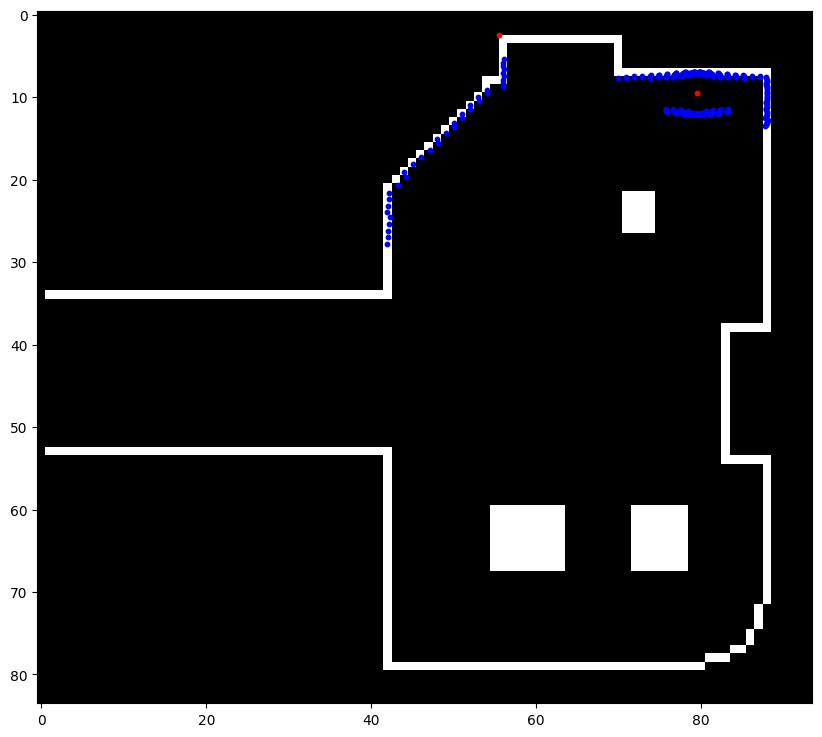

In [186]:
# Plot results
# (note that imshow treates pixels as centered on their coordinate, and spanning range (-0.5,+0.5), so the coordinates have to be adjusted by adding (-0.5,-0.5) when overlaying)
loc = (60, 25)
loc = (80, 10)
points = lds_to_2d(lds_sample(arch, loc, 0.0), loc, 0.0)
print(f"points: {points.shape}")
plt.figure(figsize=(10, 10))
plt.imshow(arch, cmap='gray')
#for x, y in points:
#  plt.plot([loc[0]-0.5, x-0.5], [loc[1]-0.5, y-0.5], color='grey', linewidth=0.5)
plt.scatter(loc[0]-0.5, loc[1]-0.5, c='r', s=10)
plt.scatter(56-0.5, 3-0.5, c='r', s=10)
plt.scatter(points[:,0]-0.5, points[:,1]-0.5, c='b', s=10)
plt.show()